In [1]:
%matplotlib inline
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano

plt.style.use('seaborn-darkgrid')

In [2]:
def achaBt(t, tempos, B0, rho, method = "r"):
    indice = 0
    beta = B0
    
    if t <= tempos[0]:
        if method == "r":
            beta = beta * (1 - rho[indice])
        else:
            beta = beta * math.exp(- rho[indice] * t)
        return beta, indice
    
    while t >= tempos[indice]:
        if indice == len(tempos) - 1 or t < tempos[indice + 1]:
            if t == tempos[indice - 1]:
                return beta, indice
            if method == "r":
                beta = beta * (1 - rho[indice] * (t - tempos[indice - 1]) / t)
            else:
                beta = beta * math.exp(- rho[indice] * (t - tempos[indice]))
                
            return beta, indice
        
        else:
            if indice == 0:
                if method == "r":
                    beta = beta * (1 - rho[indice])
                else:
                    beta = beta * math.exp(- rho[indice] * t)
            else:
                if method == "r":
                    beta = beta * (1 - rho[indice] * (tempos[indice] - tempos[indice - 1]) / tempos[indice])
                else:
                    beta = beta * math.exp(- rho[indice] * (tempos[indice] - tempos[indice - 1]))
            
        indice += 1
    

In [3]:
def model(comp, t, params):
    # alpha e f fixos aqui
    S = comp[0]
    E = comp[1]
    I = comp[2]
    R = comp[3]
    D = comp[4]
    A = comp[5]
    
#     S, E, I, R, D, A = comp
#     B0, Ti, t0, alpha, rho, f = params
    B0 = params[0]
    Ti = params[1]
    t0 = params[2]
    alpha = params[3]
    rho = params[4]
    f = params[5]
    
    method = 'r'
    '''
        S, E, I, R e D são os compartimentos usuais.
        B0 é o valor inicial de beta
        Ti é a taxa de mortalidade
        tempos é a partição do tempo que estamos fazendo (dia inicial de cada período, sem considerar o dia 0)
        alpha é constantes
        rho é o vetor dos rho_k para cada intervalo de tempo (usados na função de beta)
        f é constante também
    '''
    N = S + E + I + R + D
    beta = B0 * (1 - rho * (t - t0) / t)
        
    dS = -beta / N * S * I
    dE = beta / N * S * I - alpha * E
    dI = alpha * E - I / Ti
    dR = (1 - f) / Ti * I
    dD = f / Ti * I
    dA = alpha * E
    
    return [
        dS,
        dE,
        dI,
        dR,
        dD,
        dA
    ]

In [4]:
pop = 60461828
inits = [1 - 1e-6, 0, 1e-6, 0, 0, 0]

t = [0, 22, 93, 135, 177, 226, 265, 283, 365]
B0 = [0, 2, 2, 2, 2, 2, 2, 2]
rho = [1/200, 93/250, 999/1000, 801/1000, 1/2, 801/1000, 247/1000, 83/500]
Ti = [10, 3, 9, 14, 29, 29, 29, 99]
alpha = [1/200, 153/500, 17/1000, 3/1000, 7/1000, 57/500, 13/500, 7/250]
f = [1/200, 1/200, 1/200, 1/200, 1/200, 7/1000, 1/40, 867/1000]

In [5]:
seird_model = DifferentialEquation(
    func=model,
    times=np.arange(23, 93, 0.25),
    n_states=6,
    n_theta=6,
    t0=0.0,
)

tspan = [23, 93]

real_data = np.genfromtxt('data.csv', delimiter=',')[1:]
data =[]

for k in real_data:
    if tspan[0] <= k[0] <= tspan[1]:
        data.append((k[0], k[1]/pop))

with pm.Model() as model4:
#     sigma = pm.HalfCauchy('sigma', 1, shape=6)

    # Distribuições a priori
    # R0 é limitada inferiormente em 1 para sempre termos uma epidemia.
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3)
    
    B0 = pm.Beta('B0', mu = 0.2, sigma = 0.3)
    Ti = pm.Deterministic('Ti', R0 / B0)
    t0 = 0
    alpha = pm.Beta('alpha', mu = 0.1, sigma = .025)
    rho = pm.Beta('rho', mu = 0.5, sigma = 0.4)
    f = pm.Beta('f', mu = 0.05, sigma = 0.04)
    
    seird_curves = seird_model([1 - 1e-6, 0, 1e-6, 0, 0, 0], [B0, Ti, t0, alpha, rho, f])

#     Y = pm.Lognormal('Y', mu=pm.math.log(seird_curves), sigma=sigma, observed=data)
    db = pm.backends.HDF5('traces.h5') # Salva as amostras e assim evita de manter tudo na memória
    trace = pm.sample(8000, tune=1000,trace=db)#, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f, rho, alpha, B0, R0]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 396 seconds.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 118 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 118 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 118 divergences after tuning. Increase `t

In [6]:
data = az.from_pymc3(trace=trace)
data

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Inference data with groups:
	> posterior

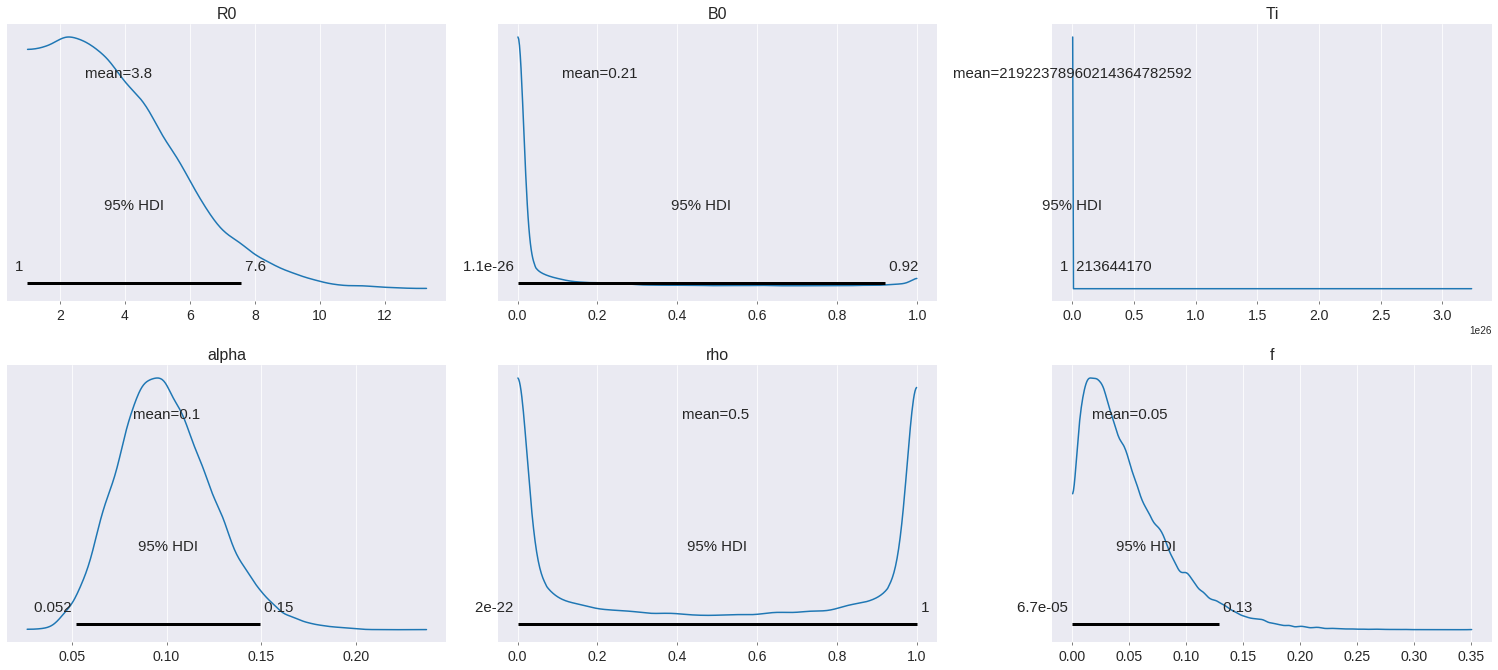

In [7]:
az.plot_posterior(data, round_to=2, hdi_prob=0.95);

In [8]:
seird_model = DifferentialEquation(
    func=model,
    times=np.arange(93, 135, 0.25),
    n_states=6,
    n_theta=6,
    t0=0.0,
)

tspan = [93, 135]

real_data = np.genfromtxt('data.csv', delimiter=',')[1:]
data =[]

for k in real_data:
    if tspan[0] <= k[0] <= tspan[1]:
        data.append((k[0], k[1]/pop))

with pm.Model() as model4:
#     sigma = pm.HalfCauchy('sigma', 1, shape=6)

    # Distribuições a priori
    # R0 é limitada inferiormente em 1 para sempre termos uma epidemia.
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3)
    
    B0 = pm.Beta('B0', mu = 0.2, sigma = 0.3)
    Ti = pm.Deterministic('Ti', R0 / B0)
    t0 = 0
    alpha = pm.Beta('alpha', mu = 0.1, sigma = .025)
    rho = pm.Beta('rho', mu = 0.5, sigma = 0.4)
    f = pm.Beta('f', mu = 0.05, sigma = 0.04)
    
    seird_curves = seird_model([1 - 1e-6, 0, 1e-6, 0, 0, 0], [B0, Ti, t0, alpha, rho, f])

#     Y = pm.Lognormal('Y', mu=pm.math.log(seird_curves), sigma=sigma, observed=data)
    db = pm.backends.HDF5('traces.h5') # Salva as amostras e assim evita de manter tudo na memória
    trace = pm.sample(8000, tune=1000,trace=db)#, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f, rho, alpha, B0, R0]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 405 seconds.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `targ

In [9]:
data = az.from_pymc3(trace=trace)
data

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Inference data with groups:
	> posterior

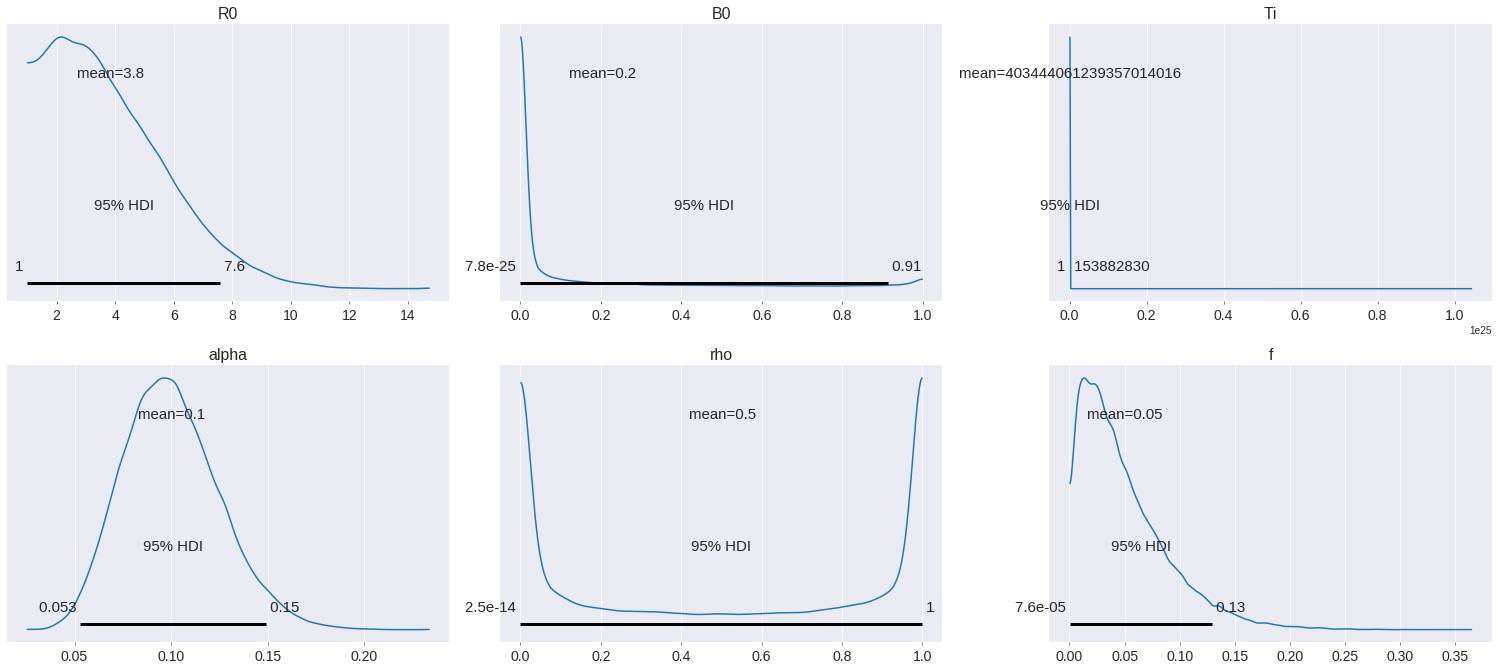

In [10]:
az.plot_posterior(data, round_to=2, hdi_prob=0.95);

In [11]:
seird_model = DifferentialEquation(
    func=model,
    times=np.arange(135, 177, 0.25),
    n_states=6,
    n_theta=6,
    t0=0.0,
)

tspan = [135, 177]

real_data = np.genfromtxt('data.csv', delimiter=',')[1:]
data =[]

for k in real_data:
    if tspan[0] <= k[0] <= tspan[1]:
        data.append((k[0], k[1]/pop))

with pm.Model() as model4:
#     sigma = pm.HalfCauchy('sigma', 1, shape=6)

    # Distribuições a priori
    # R0 é limitada inferiormente em 1 para sempre termos uma epidemia.
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3)
    
    B0 = pm.Beta('B0', mu = 0.2, sigma = 0.3)
    Ti = pm.Deterministic('Ti', R0 / B0)
    t0 = 0
    alpha = pm.Beta('alpha', mu = 0.1, sigma = .025)
    rho = pm.Beta('rho', mu = 0.5, sigma = 0.4)
    f = pm.Beta('f', mu = 0.05, sigma = 0.04)
    
    seird_curves = seird_model([1 - 1e-6, 0, 1e-6, 0, 0, 0], [B0, Ti, t0, alpha, rho, f])

#     Y = pm.Lognormal('Y', mu=pm.math.log(seird_curves), sigma=sigma, observed=data)
    db = pm.backends.HDF5('traces.h5') # Salva as amostras e assim evita de manter tudo na memória
    trace = pm.sample(8000, tune=1000,trace=db)#, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f, rho, alpha, B0, R0]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 405 seconds.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
There were 96 divergences after tuning. Increase `targ

In [12]:
data = az.from_pymc3(trace=trace)
data

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Inference data with groups:
	> posterior

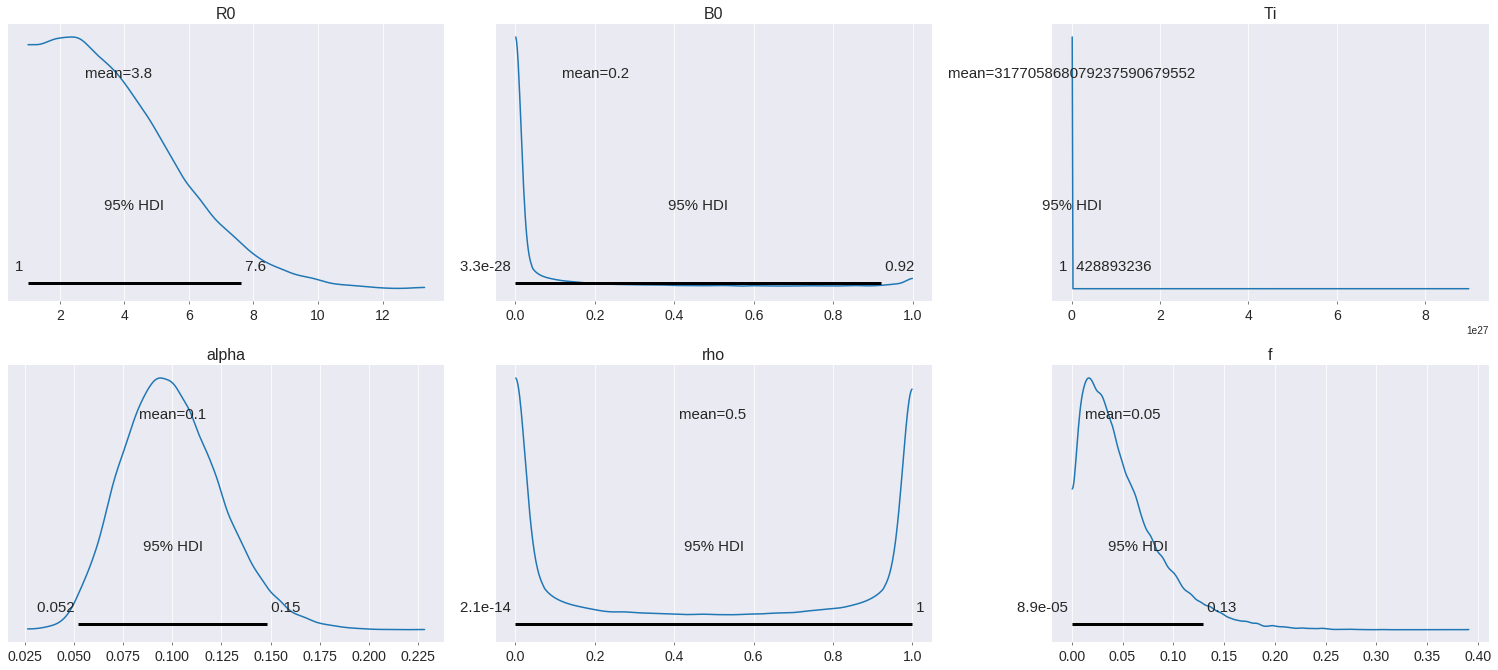

In [13]:
az.plot_posterior(data, round_to=2, hdi_prob=0.95);

In [14]:
seird_model = DifferentialEquation(
    func=model,
    times=np.arange(177, 226, 0.25),
    n_states=6,
    n_theta=6,
    t0=0.0,
)

tspan = [177, 226]

real_data = np.genfromtxt('data.csv', delimiter=',')[1:]
data =[]

for k in real_data:
    if tspan[0] <= k[0] <= tspan[1]:
        data.append((k[0], k[1]/pop))

with pm.Model() as model4:
#     sigma = pm.HalfCauchy('sigma', 1, shape=6)

    # Distribuições a priori
    # R0 é limitada inferiormente em 1 para sempre termos uma epidemia.
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3)
    
    B0 = pm.Beta('B0', mu = 0.2, sigma = 0.3)
    Ti = pm.Deterministic('Ti', R0 / B0)
    t0 = 0
    alpha = pm.Beta('alpha', mu = 0.1, sigma = .025)
    rho = pm.Beta('rho', mu = 0.5, sigma = 0.4)
    f = pm.Beta('f', mu = 0.05, sigma = 0.04)
    
    seird_curves = seird_model([1 - 1e-6, 0, 1e-6, 0, 0, 0], [B0, Ti, t0, alpha, rho, f])

#     Y = pm.Lognormal('Y', mu=pm.math.log(seird_curves), sigma=sigma, observed=data)
    db = pm.backends.HDF5('traces.h5') # Salva as amostras e assim evita de manter tudo na memória
    trace = pm.sample(8000, tune=1000,trace=db)#, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f, rho, alpha, B0, R0]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 412 seconds.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `targ

In [15]:
data = az.from_pymc3(trace=trace)
data

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Inference data with groups:
	> posterior

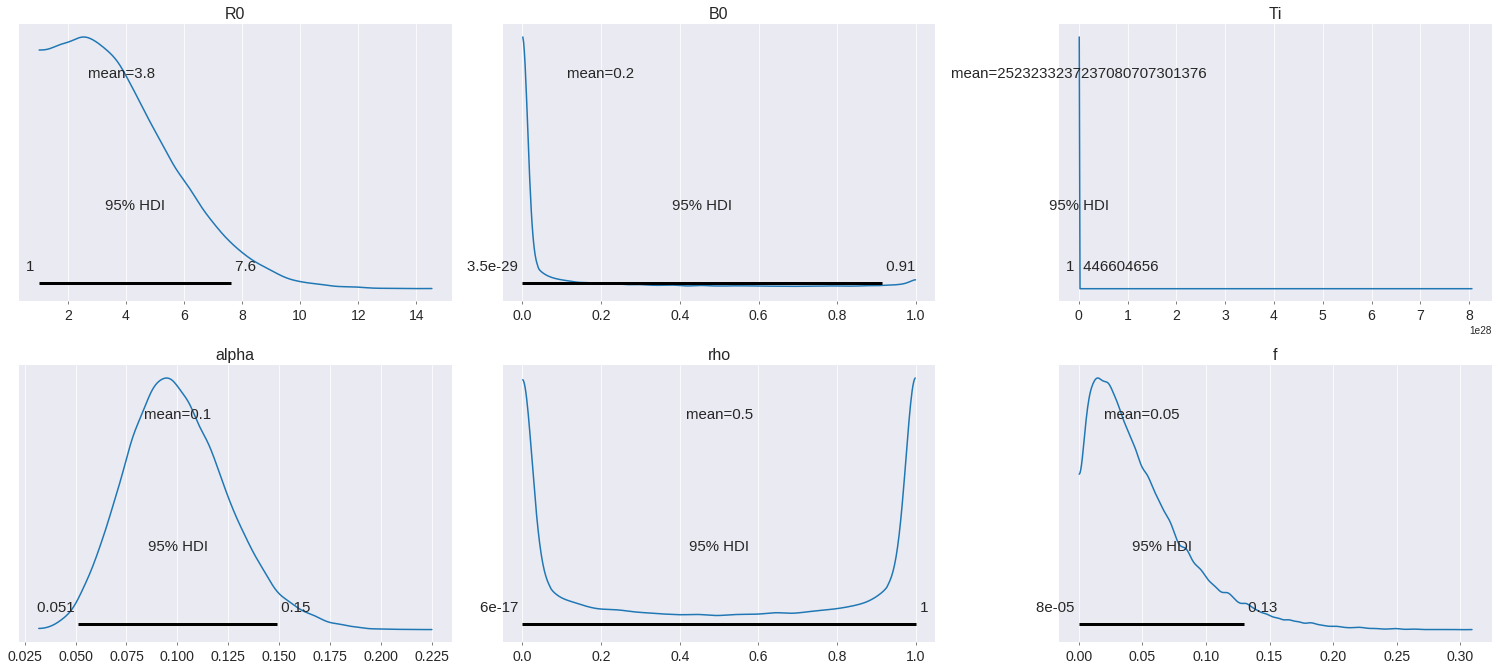

In [16]:
az.plot_posterior(data, round_to=2, hdi_prob=0.95);

In [17]:
seird_model = DifferentialEquation(
    func=model,
    times=np.arange(226, 265, 0.25),
    n_states=6,
    n_theta=6,
    t0=0.0,
)

tspan = [226, 265]

real_data = np.genfromtxt('data.csv', delimiter=',')[1:]
data =[]

for k in real_data:
    if tspan[0] <= k[0] <= tspan[1]:
        data.append((k[0], k[1]/pop))

with pm.Model() as model4:
#     sigma = pm.HalfCauchy('sigma', 1, shape=6)

    # Distribuições a priori
    # R0 é limitada inferiormente em 1 para sempre termos uma epidemia.
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3)
    
    B0 = pm.Beta('B0', mu = 0.2, sigma = 0.3)
    Ti = pm.Deterministic('Ti', R0 / B0)
    t0 = 0
    alpha = pm.Beta('alpha', mu = 0.1, sigma = .025)
    rho = pm.Beta('rho', mu = 0.5, sigma = 0.4)
    f = pm.Beta('f', mu = 0.05, sigma = 0.04)
    
    seird_curves = seird_model([1 - 1e-6, 0, 1e-6, 0, 0, 0], [B0, Ti, t0, alpha, rho, f])

#     Y = pm.Lognormal('Y', mu=pm.math.log(seird_curves), sigma=sigma, observed=data)
    db = pm.backends.HDF5('traces.h5') # Salva as amostras e assim evita de manter tudo na memória
    trace = pm.sample(8000, tune=1000,trace=db)#, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f, rho, alpha, B0, R0]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 412 seconds.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
There were 81 divergences after tuning. Increase `targ

In [18]:
data = az.from_pymc3(trace=trace)
data

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Inference data with groups:
	> posterior

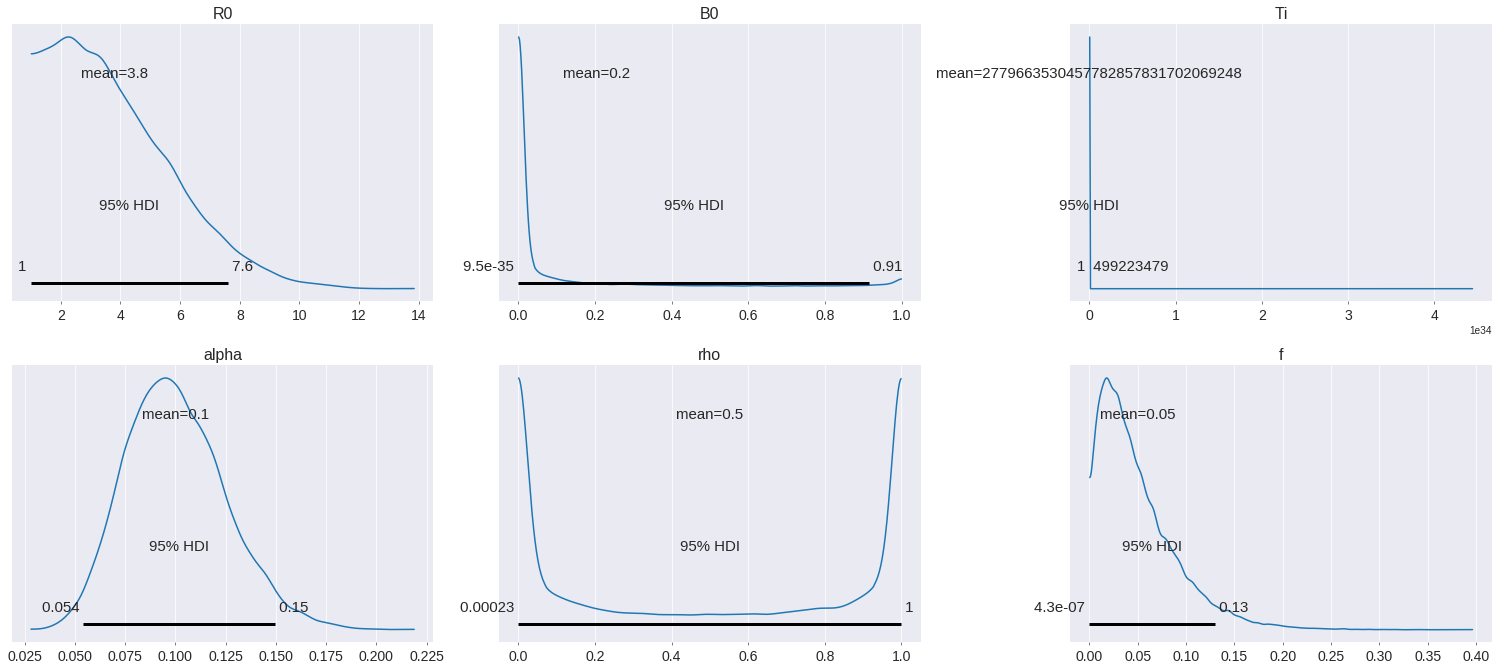

In [19]:
az.plot_posterior(data, round_to=2, hdi_prob=0.95);

In [20]:
seird_model = DifferentialEquation(
    func=model,
    times=np.arange(265, 283, 0.25),
    n_states=6,
    n_theta=6,
    t0=0.0,
)

tspan = [265, 283]

real_data = np.genfromtxt('data.csv', delimiter=',')[1:]
data =[]

for k in real_data:
    if tspan[0] <= k[0] <= tspan[1]:
        data.append((k[0], k[1]/pop))

with pm.Model() as model4:
#     sigma = pm.HalfCauchy('sigma', 1, shape=6)

    # Distribuições a priori
    # R0 é limitada inferiormente em 1 para sempre termos uma epidemia.
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3)
    
    B0 = pm.Beta('B0', mu = 0.2, sigma = 0.3)
    Ti = pm.Deterministic('Ti', R0 / B0)
    t0 = 0
    alpha = pm.Beta('alpha', mu = 0.1, sigma = .025)
    rho = pm.Beta('rho', mu = 0.5, sigma = 0.4)
    f = pm.Beta('f', mu = 0.05, sigma = 0.04)
    
    seird_curves = seird_model([1 - 1e-6, 0, 1e-6, 0, 0, 0], [B0, Ti, t0, alpha, rho, f])

#     Y = pm.Lognormal('Y', mu=pm.math.log(seird_curves), sigma=sigma, observed=data)
    db = pm.backends.HDF5('traces.h5') # Salva as amostras e assim evita de manter tudo na memória
    trace = pm.sample(8000, tune=1000,trace=db)#, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f, rho, alpha, B0, R0]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 425 seconds.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 139 divergences after tuning. Increase `target_accept` or reparameterize.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 139 divergences after tuning. Increase `target_accept` or reparameterize.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase 

In [21]:
data = az.from_pymc3(trace=trace)
data

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Inference data with groups:
	> posterior

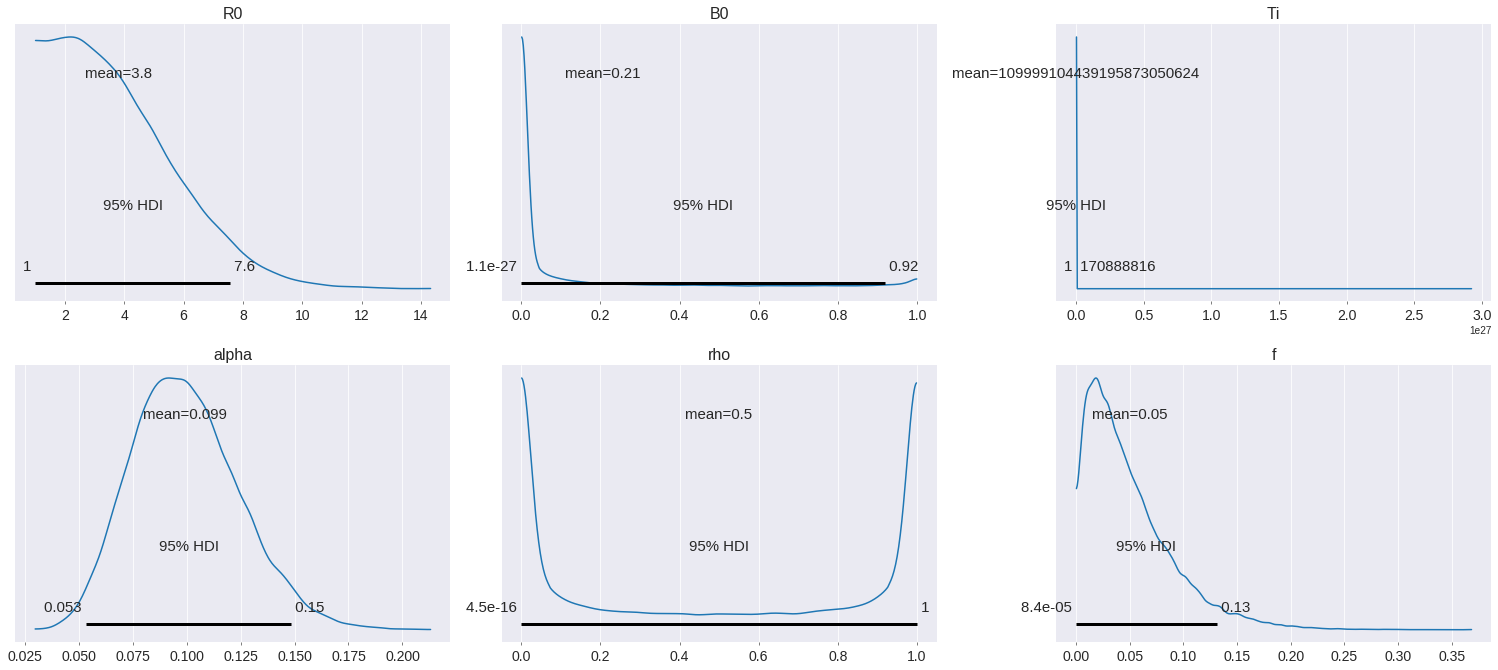

In [22]:
az.plot_posterior(data, round_to=2, hdi_prob=0.95);

In [23]:
seird_model = DifferentialEquation(
    func=model,
    times=np.arange(283, 322, 0.25),
    n_states=6,
    n_theta=6,
    t0=0.0,
)

tspan = [283, 322]

real_data = np.genfromtxt('data.csv', delimiter=',')[1:]
data =[]

for k in real_data:
    if tspan[0] <= k[0] <= tspan[1]:
        data.append((k[0], k[1]/pop))

with pm.Model() as model4:
#     sigma = pm.HalfCauchy('sigma', 1, shape=6)

    # Distribuições a priori
    # R0 é limitada inferiormente em 1 para sempre termos uma epidemia.
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3)
    
    B0 = pm.Beta('B0', mu = 0.2, sigma = 0.3)
    Ti = pm.Deterministic('Ti', R0 / B0)
    t0 = 0
    alpha = pm.Beta('alpha', mu = 0.1, sigma = .025)
    rho = pm.Beta('rho', mu = 0.5, sigma = 0.4)
    f = pm.Beta('f', mu = 0.05, sigma = 0.04)
    
    seird_curves = seird_model([1 - 1e-6, 0, 1e-6, 0, 0, 0], [B0, Ti, t0, alpha, rho, f])

#     Y = pm.Lognormal('Y', mu=pm.math.log(seird_curves), sigma=sigma, observed=data)
    db = pm.backends.HDF5('traces.h5') # Salva as amostras e assim evita de manter tudo na memória
    trace = pm.sample(8000, tune=1000,trace=db)#, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f, rho, alpha, B0, R0]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 422 seconds.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `targ

In [24]:
data = az.from_pymc3(trace=trace)
data

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Inference data with groups:
	> posterior

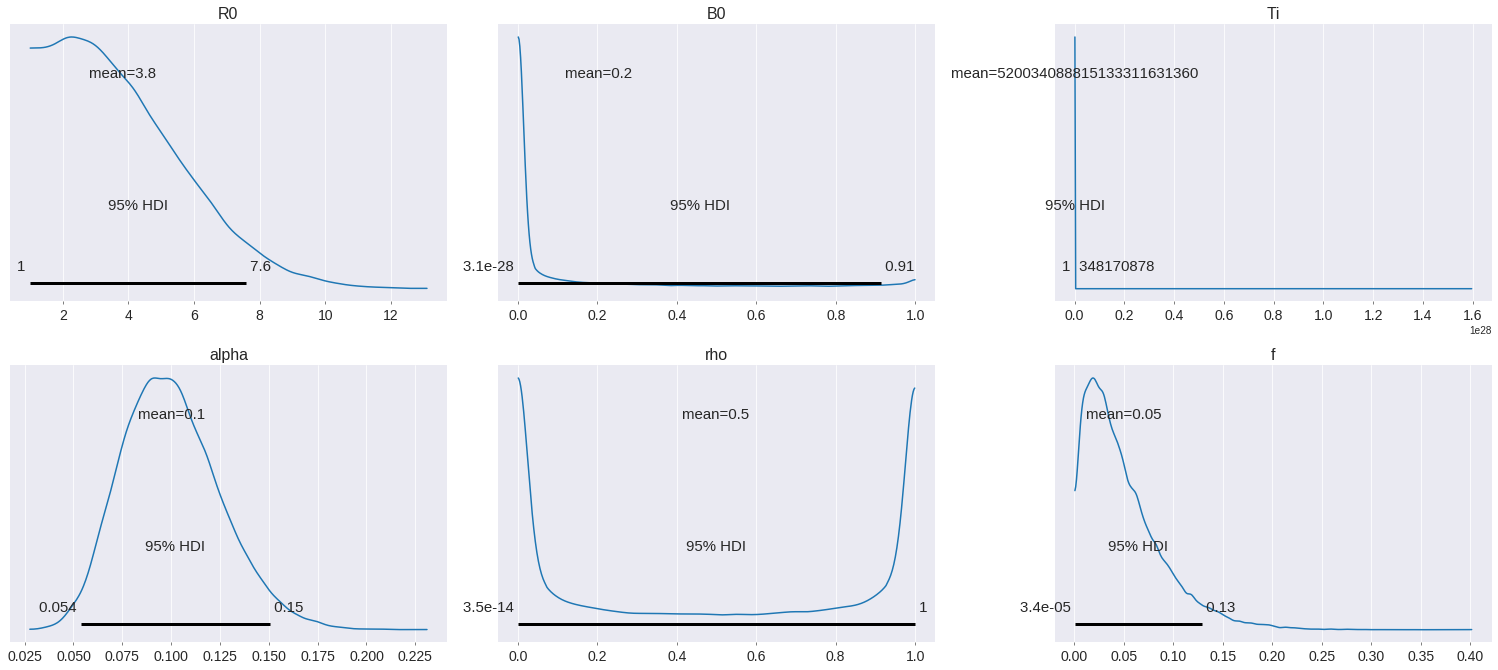

In [25]:
az.plot_posterior(data, round_to=2, hdi_prob=0.95);

In [26]:
seird_model = DifferentialEquation(
    func=model,
    times=np.arange(23, 322, 0.25),
    n_states=6,
    n_theta=6,
    t0=0.0,
)

tspan = [23, 322]

real_data = np.genfromtxt('data.csv', delimiter=',')[1:]
data =[]

for k in real_data:
    if tspan[0] <= k[0] <= tspan[1]:
        data.append((k[0], k[1]/pop))

with pm.Model() as model4:
#     sigma = pm.HalfCauchy('sigma', 1, shape=6)

    # Distribuições a priori
    # R0 é limitada inferiormente em 1 para sempre termos uma epidemia.
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3)
    
    B0 = pm.Beta('B0', mu = 0.2, sigma = 0.3)
    Ti = pm.Deterministic('Ti', R0 / B0)
    t0 = 0
    alpha = pm.Beta('alpha', mu = 0.1, sigma = .025)
    rho = pm.Beta('rho', mu = 0.5, sigma = 0.4)
    f = pm.Beta('f', mu = 0.05, sigma = 0.04)
    
    seird_curves = seird_model([1 - 1e-6, 0, 1e-6, 0, 0, 0], [B0, Ti, t0, alpha, rho, f])

#     Y = pm.Lognormal('Y', mu=pm.math.log(seird_curves), sigma=sigma, observed=data)
    db = pm.backends.HDF5('traces.h5') # Salva as amostras e assim evita de manter tudo na memória
    trace = pm.sample(8000, tune=1000,trace=db)#, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f, rho, alpha, B0, R0]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 413 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `targ

In [27]:
data = az.from_pymc3(trace=trace)
data

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Inference data with groups:
	> posterior

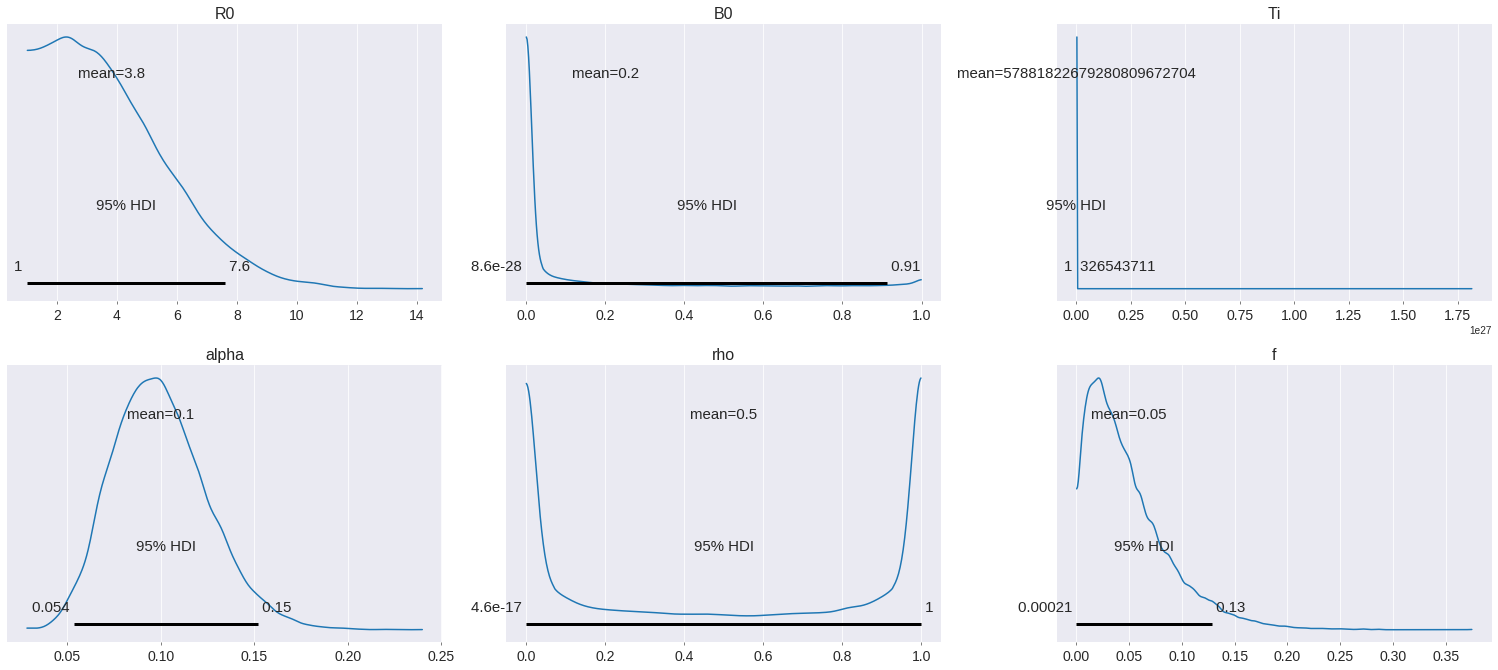

In [28]:
az.plot_posterior(data, round_to=2, hdi_prob=0.95);

In [29]:
seird_model = DifferentialEquation(
    func=model,
    times=np.arange(23, 322, 0.25),
    n_states=6,
    n_theta=6,
    t0=0.0,
)

tspan = [23, 322]

real_data = np.genfromtxt('data.csv', delimiter=',')[1:]
data =[]

for k in real_data:
    if tspan[0] <= k[0] <= tspan[1]:
        data.append((k[0], k[1]/pop))

with pm.Model() as model4:
#     sigma = pm.HalfCauchy('sigma', 1, shape=6)

    # Distribuições a priori
    # R0 é limitada inferiormente em 1 para sempre termos uma epidemia.
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3)
    
    B0 = pm.Beta('B0', mu = 0.2, sigma = 0.3)
    Ti = pm.Deterministic('Ti', R0 / B0)
    t0 = 0
    alpha = pm.Beta('alpha', mu = 0.1, sigma = .025)
    rho = pm.Beta('rho', mu = 0.5, sigma = 0.4)
    f = pm.Beta('f', mu = 0.05, sigma = 0.04)
    
    seird_curves = seird_model([1 - 1e-6, 0, 1e-6, 0, 0, 0], [B0, Ti, t0, alpha, rho, f])

#     Y = pm.Lognormal('Y', mu=pm.math.log(seird_curves), sigma=sigma, observed=data)
    db = pm.backends.HDF5('traces.h5') # Salva as amostras e assim evita de manter tudo na memória
    trace = pm.sample(8000, tune=1000,trace=db)#, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f, rho, alpha, B0, R0]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 412 seconds.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `targ

In [30]:
data = az.from_pymc3(trace=trace)
data

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Inference data with groups:
	> posterior

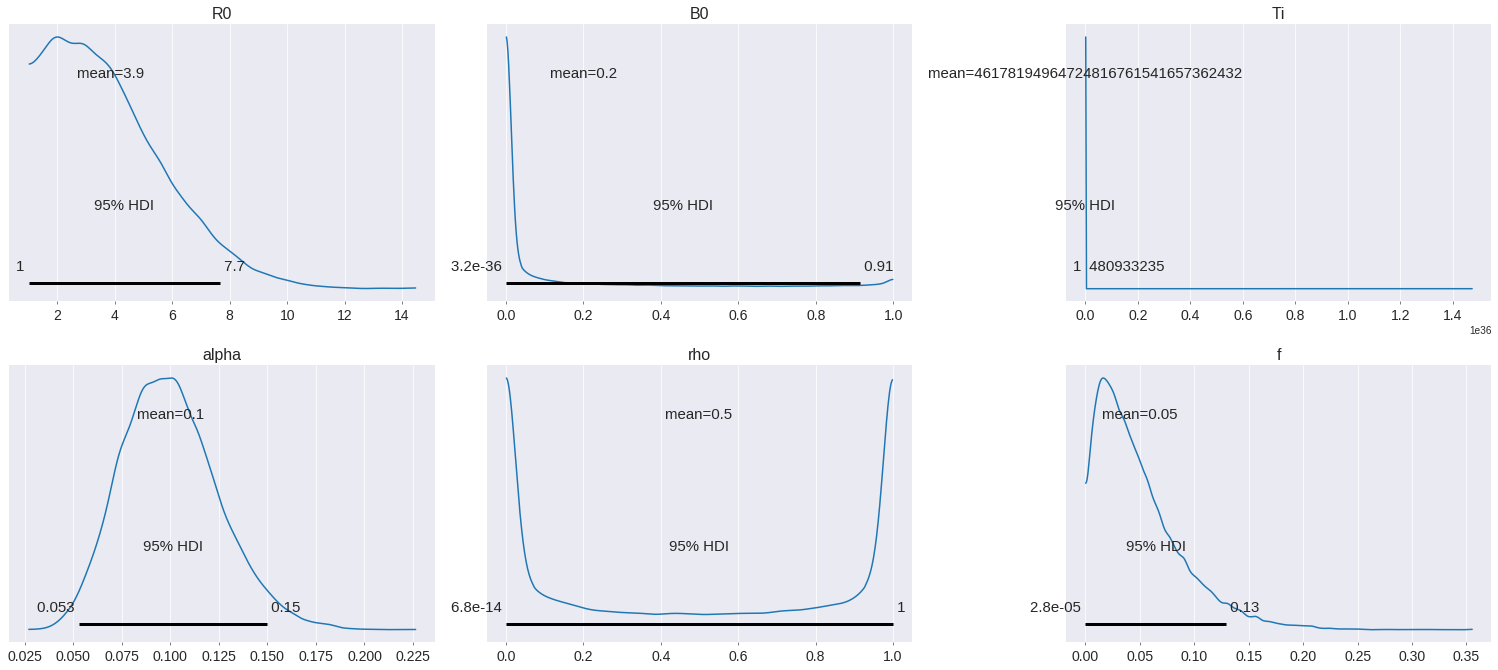

In [31]:
az.plot_posterior(data, round_to=2, hdi_prob=0.95);